### Homework 2 - Data from the Web

#### 1. Extract data

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame.

In [1]:
%matplotlib inline  
import requests
import pandas as pd
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

SOURCE="www.topuniversities.com"
LIST=SOURCE + "/university-rankings/world-university-rankings/2018"
DATA_SOURCE="www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"

LIMIT=200

In [2]:
def clean_numerical_data(data):
    return int(data.replace('\n', '').replace(',', ''))

def safe_parse(page, selector):
    try:
        return clean_numerical_data(page.select(selector)[0].text)
    except:
        return None

In [3]:
def extract_faculty_members(page):
    total = safe_parse(page, "div.total.faculty div.number")
    international = safe_parse(page, "div.inter.faculty div.number")
    return total, international
    
def extract_student_members(page):
    total = safe_parse(page, "div.total.student div.number")
    international = safe_parse(page, "div.total.inter  div.number")
    return total, international

def extract_data(university):
    url = SOURCE + university['url']
    data = requests.get("http://" + url).text
    page = BeautifulSoup(data, "html5lib")
    
    total_faculty, inter_faculty = extract_faculty_members(page)
    total_student, inter_student = extract_student_members(page)
    
    university['total_faculty'] = total_faculty
    university['inter_faculty'] = inter_faculty
    university['total_student'] = total_student
    university['inter_student'] = inter_student
    
    return university

In [4]:
def extract_list(url):
    data = requests.get("http://" + url).text
    return json.loads(data)['data']
    
university_list = extract_list(DATA_SOURCE)[:LIMIT]

In [5]:
university_list = [extract_data(university) for university in university_list]

In [6]:
KEEP = ['title', 'rank_display', 'cc', 'region', 'total_faculty', 'total_student', 'inter_faculty', 'inter_student']
university_list = [ {key: university[key] for key in KEEP} for university in university_list]

In [7]:
df = pd.DataFrame(university_list)

#### 1.b Which are the best universities in term of:

##### (a) ratio between faculty members and students

There are two possible ratio that can be used to answer this question, we can either use the **total** statistics or the **international** ones, we though it is more meaningful to use the **total** to answers this question 

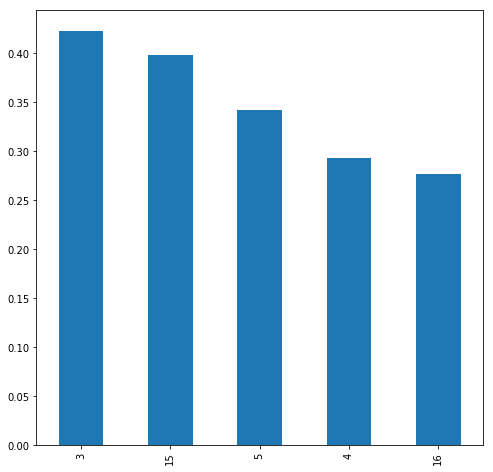

In [8]:
def staff_student_ratio(df):
    df['ratio_faculty_student'] = df['total_faculty'] / df['total_student']
    return df.sort_values('ratio_faculty_student', ascending=False)

staff_student_ratio(df)['ratio_faculty_student'].head().plot(kind='bar', figsize=(8,8))

We see that universities with the best ratio between faculty staff and students are located in the US or in GB but that this metric is not closely linked with the rank of the university

##### (b) ratio of international students?

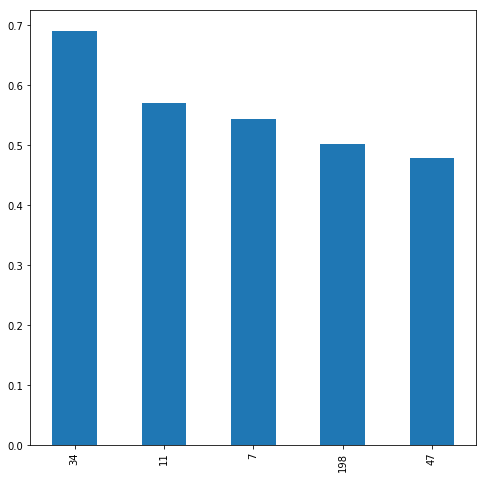

In [9]:
def inter_student_ratio(df):
    df['ratio_inter_student'] = df['inter_student'] / df['total_student']
    return df.sort_values('ratio_inter_student', ascending=False)

inter_student_ratio(df)['ratio_inter_student'].head().plot(kind='bar', figsize = (8,8))

Here, we can see that the most international university are mostly located in Europe.

We now need to compute the same ratio, but this time, we'll add some aggregation

##### Country aggregation

In [10]:
df_country = df.groupby('cc')['inter_faculty', 'inter_student', 'total_faculty', 'total_student'].sum()

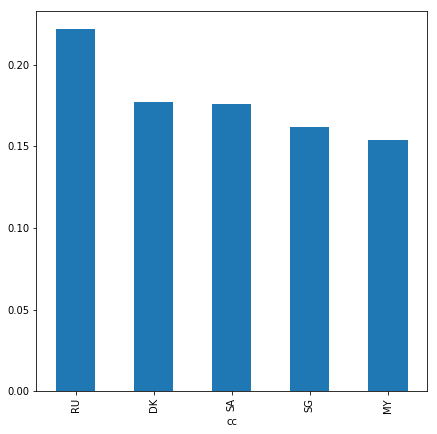

In [11]:
staff_student_ratio(df_country)['ratio_faculty_student'].head().plot(kind='bar', figsize=(7, 7))

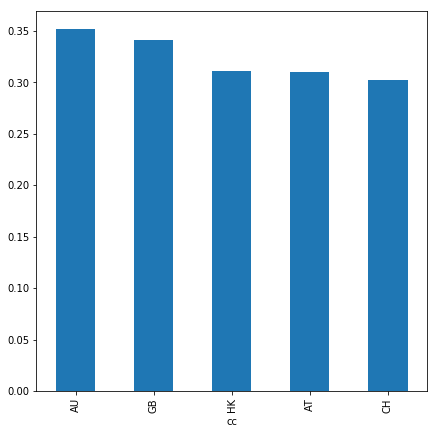

In [12]:
inter_student_ratio(df_country)['ratio_inter_student'].head().plot(kind='bar', figsize=(7, 7))

##### Region aggregation

In [13]:
df_region = df.groupby('region')['inter_faculty', 'inter_student', 'total_faculty', 'total_student'].sum()

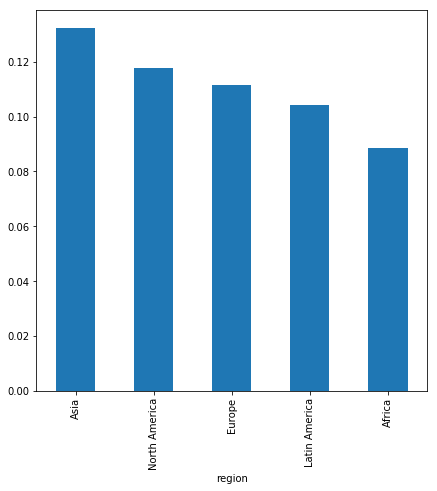

In [14]:
staff_student_ratio(df_region)['ratio_faculty_student'].head().plot(kind='bar',  figsize=(7, 7))

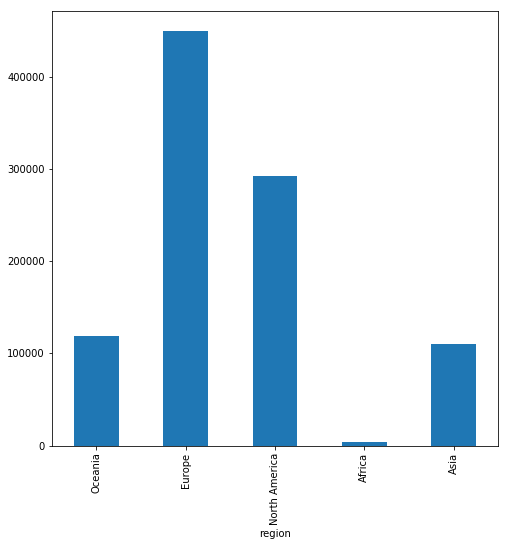

In [15]:
inter_student_ratio(df_region)['inter_student'].head().plot(kind='bar', figsize=(8,8))

In [16]:
!ls

HW00 - Gunshot Deaths.ipynb  Homework 2.ipynb  datasets
Homework 1.ipynb	     README.md
